<a href="https://colab.research.google.com/github/Arfwjn/AI-DL-Automatic_Waste_Image_Classification/blob/main/STI202303494_ARIEF_SIDIK_WIJAYANTO_UAS_DL_AUTOMATIC_WASTE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets list

ref                                                      title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
urvishahir/electric-vehicle-specifications-dataset-2025  Electric Vehicle Specs Dataset (2025)                   16631  2025-06-20 07:14:56.777000           2972         74  1.0              
sahilislam007/health-and-lifestyle-dataset               Health And Lifestyle Dataset                           123230  2025-06-25 09:52:01.580000           1795         41  1.0              
khwaishsaxena/lung-cancer-dataset                        Lung Cancer Dataset                                  19146677  2025-06-25 03:39:42.770000           1343         37  1.0              
adilshamim8/salaries-for-data-science-jo

In [4]:
!kaggle datasets download -d 'mostafaabla/garbage-classification'

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 73% 174M/239M [00:00<00:00, 794MB/s] 
100% 239M/239M [00:00<00:00, 572MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/garbage-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Image Classification dengan Deep Learning**
Studi Kasus: Klasifikasi Sampah Otomatis (Automatic Waste Classification)

1.   Nama  : Arief Sidik Wijayanto
2.   NIM    : STI202303494
3.   Kelas : C4.1


**1. Data Preparation**

In [6]:
!pip install split-folders
import splitfolders

#ekstrak data dan split data menjadi train/val/test
splitfolders.ratio("/content/garbage_classification", output="/content/garbage_data_split", seed=42, ratio=(.7, .2, .1))


Copying files: 15515 files [00:03, 4705.58 files/s]


**2. Augmentasi Data & Data Loader**

In [7]:
#mempersiapkan dataset gambar sebelum di training dan meng-augmentasi gambar agar dataset lebih bervariasi

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,                      #ubah skala dari 0-255 menjadi 0-1
    rotation_range=25,                   #rotasi gambar max 25 derajat
    width_shift_range=0.2,               #geser gambar secara horizontal max 20%
    height_shift_range=0.2,              #geser gambar secara vertikal max 20%
    horizontal_flip=True,                #flip gambar secara horizontal (flip kanan-kiri)
    zoom_range=0.2,                      #zoom gambar max 20%
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#penyesuaian data
val_test_datagen = ImageDataGenerator(rescale=1./255)

#training generator
train_generator = train_datagen.flow_from_directory(
    '/content/garbage_data_split/train', target_size=(150, 150), batch_size=32, class_mode='categorical')  #ubah setiap gambar menjadi 150x150
                                                                                                           #gambar dimuat per 32 file
#validation generator
val_generator = val_test_datagen.flow_from_directory(
    '/content/garbage_data_split/val', target_size=(150, 150), batch_size=32, class_mode='categorical')

#test generator
test_generator = val_test_datagen.flow_from_directory(
    '/content/garbage_data_split/test', target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False)


Found 10854 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Found 1561 images belonging to 12 classes.


**3. Model CNN (Transfer Learning MobileNet)**

In [8]:
#import library
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

#load base model
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet') #gambar RGB berukuran 150x150.
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)      #ubah ouput menjadi 1D
x = Dense(128, activation='relu')(x) #128 neuron
x = Dropout(0.5)(x)                  #cegah overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

#buat model
model = Model(inputs=base_model.input, outputs=predictions)

#compile
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipython-input-8-3358599826.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet') #gambar RGB berukuran 150x150.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,423,500 (9.24 MB)

 Trainable params: 1,691,916 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

**4. Callbacks & Training**

In [9]:
#import library
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#lakukan callback
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

#simpan hasilnya ke variabel history_training
history_training = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks) #lakukan training 10 epoch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.2336 - loss: 2.4704

340/340 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.2340 - loss: 2.4693 - val_accuracy: 0.5623 - val_loss: 1.3457 - learning_rate: 1.0000e-05
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.5422 - loss: 1.4650

340/340 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.5423 - loss: 1.4647 - val_accuracy: 0.7455 - val_loss: 0.8926 - learning_rate: 1.0000e-05
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.6583 - loss: 1.1372

340/340 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.6583 - loss: 1.1371 - val_accuracy: 0.8142 - val_loss: 0.6660 - learning_rate: 1.0000e-05
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.7244 - loss: 0.9296

340/340 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.7244 - loss: 0.9296 - val_accuracy: 0.8403 - val_loss: 0.5407 - learning_rate: 1.0000e-05
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.7491 - loss: 0.8415

340/340 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.7491 - loss: 0.8414 - val_accuracy: 0.8558 - val_loss: 0.4649 - learning_rate: 1.0000e-05
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.7812 - loss: 0.7384

340/340 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.7812 - loss: 0.7383 - val_accuracy: 0.8735 - val_loss: 0.4127 - learning_rate: 1.0000e-05
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.7915 - loss: 0.6892

340/340 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7915 - loss: 0.6892 - val_accuracy: 0.8826 - val_loss: 0.3758 - learning_rate: 1.0000e-05
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.8139 - loss: 0.6168

340/340 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.8139 - loss: 0.6168 - val_accuracy: 0.8910 - val_loss: 0.3455 - learning_rate: 1.0000e-05
Epoch 9/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.8214 - loss: 0.5729

340/340 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.8214 - loss: 0.5729 - val_accuracy: 0.8994 - val_loss: 0.3209 - learning_rate: 1.0000e-05
Epoch 10/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8272 - loss: 0.5575

340/340 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.8272 - loss: 0.5575 - val_accuracy: 0.9042 - val_loss: 0.2996 - learning_rate: 1.0000e-05


**5. Evaluasi Hasil**

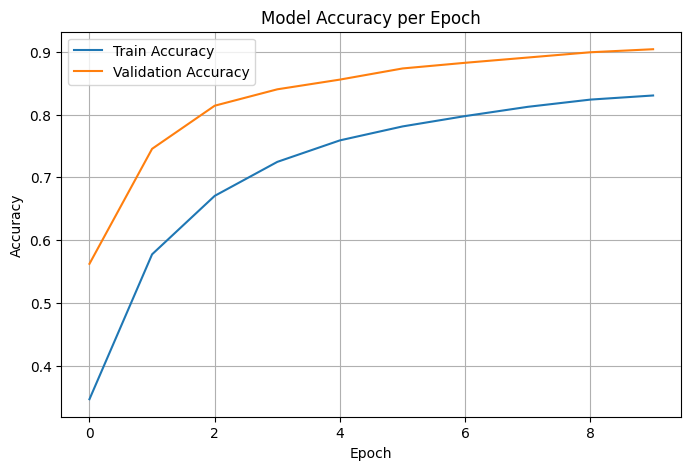

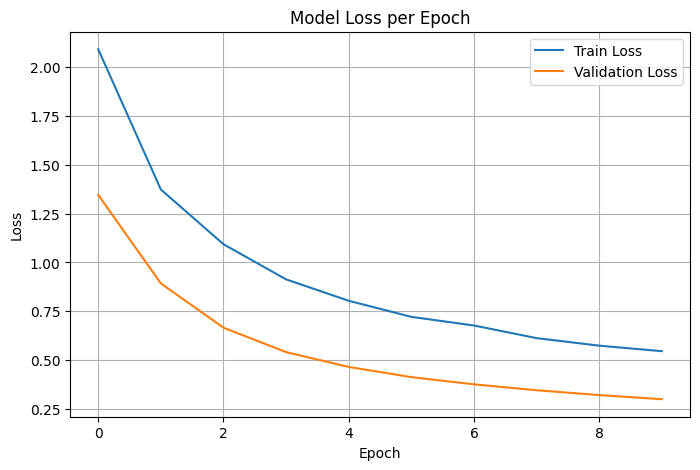

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 520ms/step


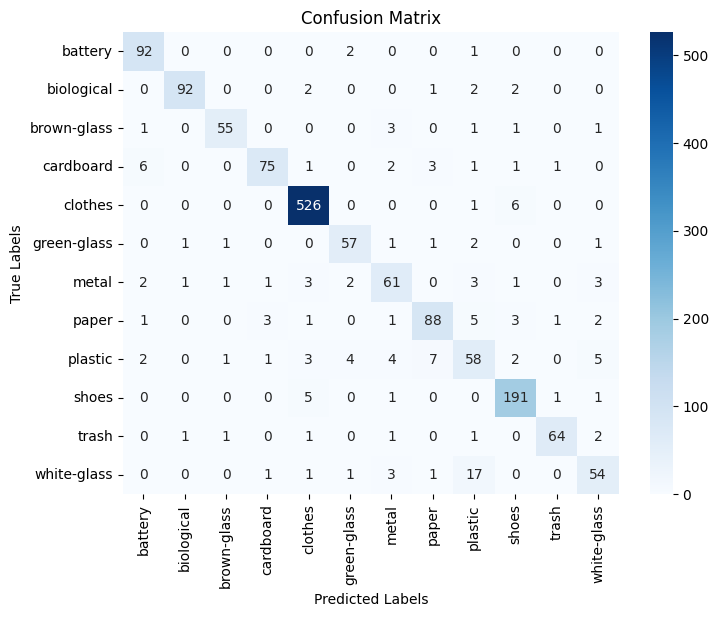

              precision    recall  f1-score   support

     battery       0.88      0.97      0.92        95
  biological       0.97      0.93      0.95        99
 brown-glass       0.93      0.89      0.91        62
   cardboard       0.93      0.83      0.88        90
     clothes       0.97      0.99      0.98       533
 green-glass       0.86      0.89      0.88        64
       metal       0.79      0.78      0.79        78
       paper       0.87      0.84      0.85       105
     plastic       0.63      0.67      0.65        87
       shoes       0.92      0.96      0.94       199
       trash       0.96      0.90      0.93        71
 white-glass       0.78      0.69      0.73        78

    accuracy                           0.91      1561
   macro avg       0.87      0.86      0.87      1561
weighted avg       0.91      0.91      0.90      1561



In [10]:
#import library
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

#grafik akurasi
plt.figure(figsize=(8, 5))
plt.plot(history_training.history['accuracy'], label="Train Accuracy")
plt.plot(history_training.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

#grafik loss
plt.figure(figsize=(8, 5))
plt.plot(history_training.history['loss'], label="Train Loss")
plt.plot(history_training.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#prediksi data uji
y_true = test_generator.classes  #data asli
y_pred = np.argmax(model.predict(test_generator), axis=1)  #data prediksi kelas

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#tampilkan dan simpan laporan klasifikasi
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

#simpan report ke .txt
with open("classification_report.txt", "w") as f:
    f.write(report)


**6. Load Model**

In [11]:
from tensorflow.keras.models import load_model
import numpy as np
import os
from tensorflow.keras.preprocessing import image

#load model yang sudah dilatih
model = load_model('best_model.h5')

#mapping label index ke nama label
label_map = train_generator.class_indices
label_map = dict((v,k) for k,v in label_map.items())  #balik dictionary jadi {0: 'battery', 1: 'biological', ...}


**7. Prediksi Gambar**

In [12]:
from PIL import Image

def predict_image(img_path):
    #buka dan resize gambar
    img = Image.open(img_path).convert('RGB')
    img = img.resize((150, 150))  #ukuran input harus sama dengan model

    #convert jadi array
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  #ubah jadi bentuk (1, 150, 150, 3)

    #mulai prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_label = label_map[predicted_class]

    return class_label, prediction[0][predicted_class]


**8. Penggunaan**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediksi: biological (Confidence: 0.24)


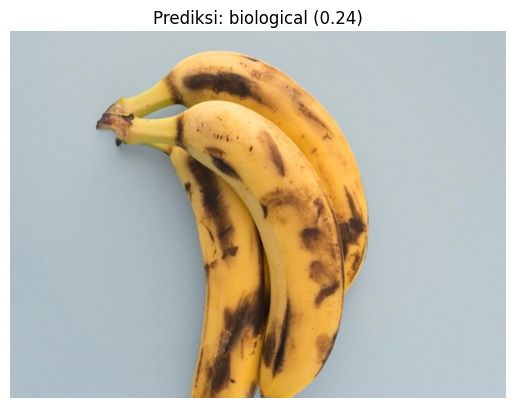

In [14]:
import matplotlib.pyplot as plt

img_path = '/content/pisang-AI-Pred.jpg'  #path gambar uji

label, confidence = predict_image(img_path)
print(f"Prediksi: {label} (Confidence: {confidence:.2f})")

img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Prediksi: {label} ({confidence:.2f})")
plt.axis('off')
plt.show()
